# Solarzelle

## initial imports

In [1]:
# %matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import scipy.constants as con
import uncertainties as un
import uncertainties.unumpy as unp
from scipy.signal import find_peaks,find_peaks_cwt
import scipy.signal as sig
import scipy.special as sp
import scienceplots
plt.figure()
plt.style.use('science')
plt.rcParams['errorbar.capsize'] = 5
plt.rcParams['text.usetex'] = False # disable latex
plt.rcParams['figure.dpi'] = 150
import os
import fp

<Figure size 640x480 with 0 Axes>

In [2]:
#aliases
from uncertainties import ufloat as uf
from uncertainties.unumpy import uarray as ua
from uncertainties.unumpy import nominal_values as nv
from uncertainties.unumpy import std_devs as sd

In [3]:
outdir = f'plots/solar/'
datadir = f'data/solar/'
os.makedirs(outdir, exist_ok=True)

## Spectra

In [4]:
spec_files= !ls {datadir}/Spectrometer
spec_files

['led-kg5_1403062U1.TXT',
 'led-unfiltered_1403062U1.TXT',
 'xe-kg5_1403062U1.TXT',
 'xe-unfiltered_1403062U1.TXT']

In [5]:
spec_dat = []
for file in spec_files:
    path = f"{datadir}Spectrometer/{file}"
    print(path)
    dat = pd.read_csv(path,delimiter=';',decimal=',',names=["Wave", "Sample", "Dark", "Reference", "Corr"],skiprows=7)
    spec_dat.append(dat)
spec_dat[0]

data/solar/Spectrometer/led-kg5_1403062U1.TXT
data/solar/Spectrometer/led-unfiltered_1403062U1.TXT
data/solar/Spectrometer/xe-kg5_1403062U1.TXT
data/solar/Spectrometer/xe-unfiltered_1403062U1.TXT


,Wave,Sample,Dark,Reference,Corr
0,176.36,13.52,-1.99,-4.94,15.51
1,176.71,7.70,2.51,1.20,5.19
2,177.05,11.72,-6.62,1.62,18.34
3,177.40,6.66,-1.32,1.16,7.98
4,177.74,11.35,1.74,1.63,9.61
...,...,...,...,...,...
2797,1098.94,-7.18,3.93,4.81,-11.11
2798,1099.25,-13.30,-0.28,-2.79,-13.02
2799,1099.56,-9.34,6.42,7.06,-15.76
2800,1099.87,-6.83,3.31,-1.42,-10.14


In [6]:
spec_runs = []
for file in spec_files:
    spec_runs.append(file.split('_')[0])
spec_runs

['led-kg5', 'led-unfiltered', 'xe-kg5', 'xe-unfiltered']

In [7]:
am15g_names = ["wl", "etr", "global", "direct"]
am15g = pd.read_csv(f"{datadir}FP Solar Cells Reference Data/ASTMG173.csv",skiprows=2,names=am15g_names)
am15g

,wl,etr,global,direct
0,280.0,0.08200,4.730900e-23,2.536100e-26
1,280.5,0.09900,1.230700e-21,1.091700e-24
2,281.0,0.15000,5.689500e-21,6.125300e-24
3,281.5,0.21200,1.566200e-19,2.747900e-22
4,282.0,0.26700,1.194600e-18,2.834600e-21
...,...,...,...,...
1997,3980.0,0.00884,7.387200e-03,7.404900e-03
1998,3985.0,0.00880,7.432700e-03,7.450300e-03
1999,3990.0,0.00878,7.372300e-03,7.389400e-03
2000,3995.0,0.00870,7.210000e-03,7.226300e-03


Text(0, 0.5, 'Intensity [W/m$^2$/nm]')

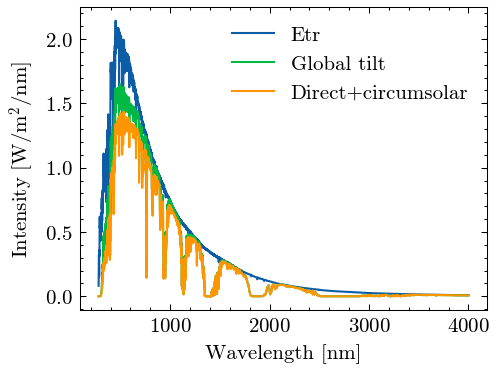

In [8]:
plt.figure()
plt.plot(am15g['wl'],am15g['etr'], label='Etr')
plt.plot(am15g['wl'],am15g['global'], label='Global tilt')
plt.plot(am15g['wl'],am15g['direct'], label='Direct+circumsolar')
plt.legend()

plt.xlabel('Wavelength [nm]')
plt.ylabel('Intensity [W/m$^2$/nm]')

In [9]:
kg_names=["kg1_wl", "kg1_tm", "kg2_wl", "kg2_tm", "kg3_wl", "kg3_tm", "kg4_wl", "kg4_tm", "kg5_wl", "kg5_tm"]
kg_filters = pd.read_csv(f"{datadir}FP Solar Cells Reference Data/Schott_KG_filters.csv",names=kg_names,skiprows=3)
kg_filters

,kg1_wl,kg1_tm,kg2_wl,kg2_tm,kg3_wl,kg3_tm,kg4_wl,kg4_tm,kg5_wl,kg5_tm
0,273.584906,0.002469,263.207547,0.00617,291.50943,0.00741,288.679245,0.003704,295.283019,0.003704
1,273.584906,0.002469,263.207547,0.00617,299.05660,0.04691,297.169811,0.032099,300.943396,0.023457
2,283.018868,0.023457,276.415094,0.04691,303.77358,0.09506,301.886793,0.072840,306.603774,0.056790
3,283.018868,0.023457,276.415094,0.04691,310.37736,0.19630,305.660377,0.119753,308.490566,0.079012
4,291.509434,0.076543,282.075472,0.09753,315.09434,0.29877,310.377359,0.180247,312.264151,0.137037
...,...,...,...,...,...,...,...,...,...,...
60,NaN,NaN,970.754717,0.14815,NaN,NaN,NaN,NaN,NaN,NaN
61,NaN,NaN,970.754717,0.14815,NaN,NaN,NaN,NaN,NaN,NaN
62,NaN,NaN,998.113208,0.12469,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,1036.792453,0.10123,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Transmission [%]')

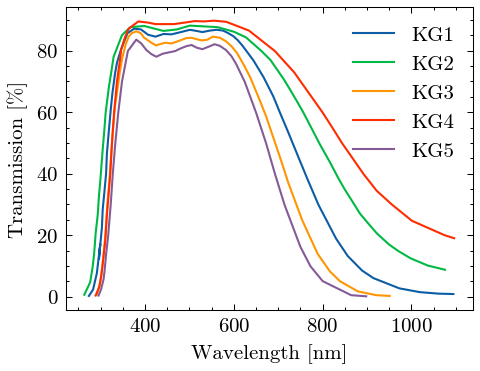

In [10]:
plt.figure()
plt.plot(kg_filters['kg1_wl'],100*kg_filters['kg1_tm'],label='KG1')
plt.plot(kg_filters['kg2_wl'],100*kg_filters['kg2_tm'],label='KG2')
plt.plot(kg_filters['kg3_wl'],100*kg_filters['kg3_tm'],label='KG3')
plt.plot(kg_filters['kg4_wl'],100*kg_filters['kg4_tm'],label='KG4')
plt.plot(kg_filters['kg5_wl'],100*kg_filters['kg5_tm'],label='KG5')

plt.legend()

plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [%]')

Text(0, 0.5, 'Intensity [counts]')

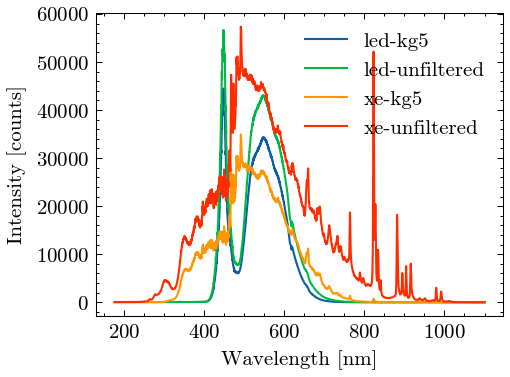

In [11]:
# without correction fot dark measurement        
plt.figure()
for d,r in zip(spec_dat,spec_runs):
    plt.plot(d['Wave'],d['Sample'],label=r)
plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel('Intensity [counts]')

Text(0, 0.5, 'Intensity [counts]')

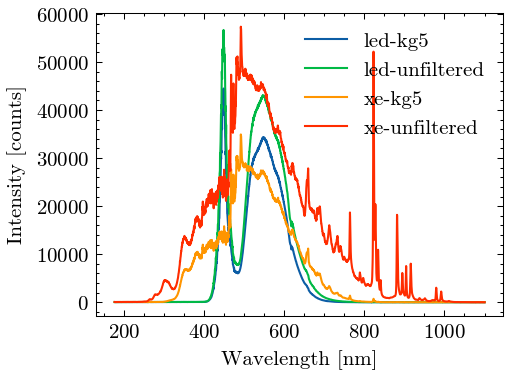

In [12]:
# without correction fot dark measurement        
plt.figure()
for d,r in zip(spec_dat,spec_runs):
    plt.plot(d['Wave'],d['Corr'],label=r)
plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel('Intensity [counts]')

## J-V

In [13]:
jv_files= !ls {datadir}/IV
jv_files

['organic-dark-bw_R001_2024-01-24_09-40-54.IV0',
 'organic-dark-fw_R001_2024-01-24_09-40-20.IV0',
 'organic-light_led-bw_R001_2024-01-24_09-37-31.IV2',
 'organic-light_led-fw_R001_2024-01-24_09-36-56.IV2',
 'organic-light_xenon-bw_R001_2024-01-24_09-39-36.IV2',
 'organic-light_xenon-fw_R001_2024-01-24_09-38-56.IV2',
 'perovskite-dark-bw_R001_2024-01-24_09-23-49.IV0',
 'perovskite-dark-fw_R001_2024-01-24_09-20-41.IV0',
 'perovskite-light_led-bw_R001_2024-01-24_09-34-56.IV2',
 'perovskite-light_led-fw_R001_2024-01-24_09-34-20.IV2',
 'perovskite-light_xenon-bw_R001_2024-01-24_09-25-36.IV2',
 'perovskite-light_xenon-fw_R001_2024-01-24_09-25-06.IV2',
 'si-dark-bw_R001_2024-01-24_09-43-32.IV0',
 'si-dark-fw_R001_2024-01-24_09-42-52.IV0',
 'si-light_led-bw_R001_2024-01-24_09-46-09.IV2',
 'si-light_led-fw_R001_2024-01-24_09-45-42.IV2',
 'si-light_xenon-bw_R001_2024-01-24_09-44-40.IV2',
 'si-light_xenon-fw_R001_2024-01-24_09-44-14.IV2']

In [14]:
jv_cell = []
jv_direction = []
jv_light = []
for file in jv_files:
    jv_cell.append(file.split('-')[0])
    jv_direction.append(file.split('-')[2].split('_')[0])
    jv_light.append(file.split('-')[1].split('_')[-1])

In [15]:

jv_dat = []
for file in jv_files:
    path = f"{datadir}IV/{file}"
    dat = pd.read_csv(path,delimiter='\t',decimal='.',comment='#',names=['I','V', 't', 'dummy'],skiprows=15)
    jv_dat.append(dat)
jv_dat[0]

,I,V,t,dummy
0,0.005609,-0.20,2437.06,NaN
1,0.005419,-0.19,2437.13,NaN
2,0.005097,-0.18,2437.20,NaN
3,0.004730,-0.17,2437.27,NaN
4,0.004506,-0.16,2437.34,NaN
...,...,...,...,...
141,-29.369100,1.21,2447.72,NaN
142,-30.327300,1.22,2447.80,NaN
143,-31.284000,1.23,2447.87,NaN
144,-32.242900,1.24,2447.94,NaN


Text(0, 0.5, 'Current [mA]')

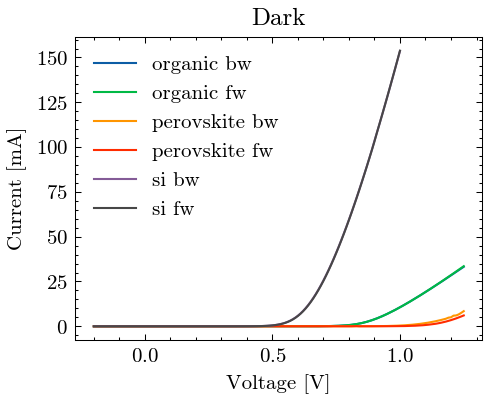

In [16]:
plt.figure()
plt.title('Dark')

for d, c , di, l in zip(jv_dat, jv_cell, jv_direction, jv_light):
    if l == 'dark':
        plt.plot(d['V'],-d['I'],label=f'{c} {di}')
plt.legend()

plt.xlabel('Voltage [V]')
plt.ylabel('Current [mA]')

Text(0, 0.5, 'Current [mA]')

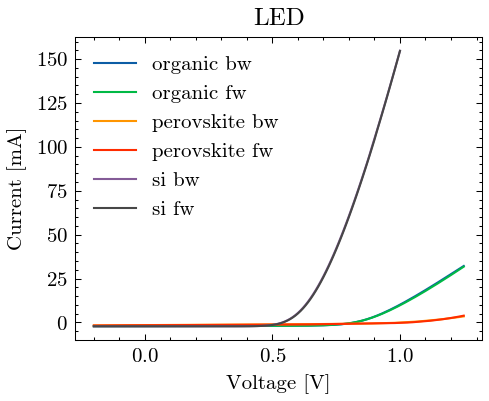

In [17]:
plt.figure()
plt.title('LED')

for d, c , di, l in zip(jv_dat, jv_cell, jv_direction, jv_light):
    if l == 'led':
        plt.plot(d['V'],-d['I'],label=f'{c} {di}')
plt.legend()

plt.xlabel('Voltage [V]')
plt.ylabel('Current [mA]')

Text(0, 0.5, 'Current [mA]')

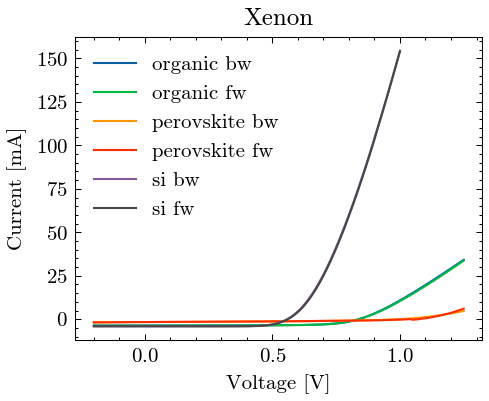

In [18]:
plt.figure()
plt.title('Xenon')
for d, c , di, l in zip(jv_dat, jv_cell, jv_direction, jv_light):
    if l == 'xenon':
        plt.plot(d['V'],-d['I'],label=f'{c} {di}')
plt.legend()

plt.xlabel('Voltage [V]')
plt.ylabel('Current [mA]')

Text(0, 0.5, 'Current [mA]')

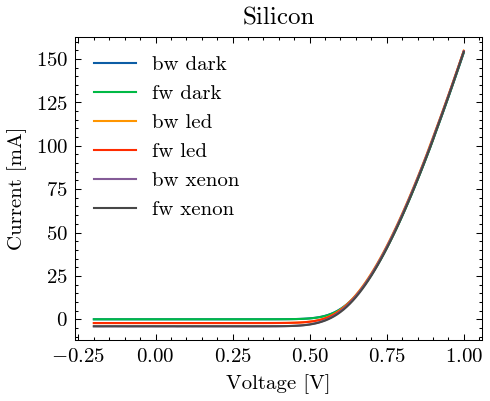

In [19]:
plt.figure()
plt.title('Silicon')
for d, c , di, l in zip(jv_dat, jv_cell, jv_direction, jv_light):
    if c == 'si':
        plt.plot(d['V'],-d['I'],label=f'{di} {l}')
plt.legend()

plt.xlabel('Voltage [V]')
plt.ylabel('Current [mA]')

Text(0, 0.5, 'Current [mA]')

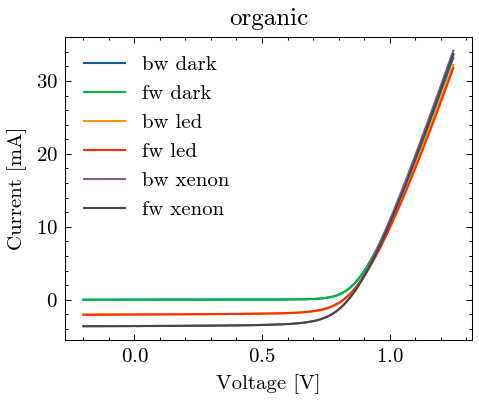

In [20]:
plt.figure()
plt.title('organic')
for d, c , di, l in zip(jv_dat, jv_cell, jv_direction, jv_light):
    if c == 'organic':
        plt.plot(d['V'],-d['I'],label=f'{di} {l}')
plt.legend()

plt.xlabel('Voltage [V]')
plt.ylabel('Current [mA]')

Text(0, 0.5, 'Current [mA]')

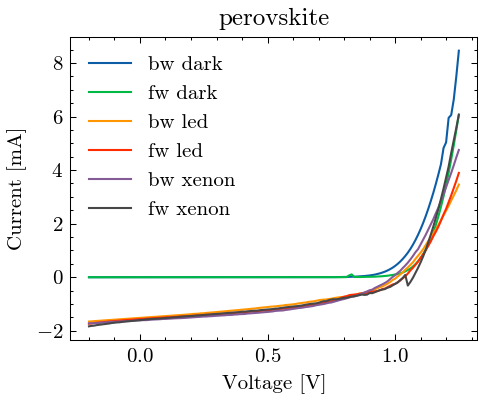

In [21]:
plt.figure()
plt.title('perovskite')
for d, c , di, l in zip(jv_dat, jv_cell, jv_direction, jv_light):
    if c == 'perovskite':
        plt.plot(d['V'],-d['I'],label=f'{di} {l}')
plt.legend()

plt.xlabel('Voltage [V]')
plt.ylabel('Current [mA]')

## EQE

In [22]:
eqe_files= !ls {datadir}EQE
eqe_files

['daniele-test-peroEQE_2024-01-24_11-47-37.eqe',
 'organic_2024-01-24_10-55-10.eqe',
 'perovskite_2024-01-24_11-03-06.eqe']

In [23]:
eqe_dat = []
for file in eqe_files:
    path = f"{datadir}EQE/{file}"
    dat = pd.read_csv(path,delimiter='\t',decimal='.',comment='#',header=None,names=['wavelength','I','EQE','dummy'],skiprows=13)
    eqe_dat.append(dat)
eqe_dat[0]

,wavelength,I,EQE,dummy
0,390,5.811290e-07,65.311500,NaN
1,392,5.824310e-07,65.332700,NaN
2,394,5.955080e-07,65.203400,NaN
3,396,6.159210e-07,64.736200,NaN
4,398,6.356520e-07,64.745900,NaN
...,...,...,...,...
261,912,2.156670e-08,5.554790,NaN
262,914,2.117190e-08,2.340380,NaN
263,916,2.090000e-08,1.057960,NaN
264,918,2.102800e-08,0.874312,NaN


In [24]:
eqe_ref_file=f'{datadir}FP Solar Cells Reference Data/Si_refdata_EQE_SR.txt'
eqe_ref_dat = pd.read_csv(eqe_ref_file,delimiter='\t',decimal='.',comment='#',header=None,names=['wavelength','EQE'],skiprows=2)
eqe_ref_dat

,wavelength,EQE
0,350,37.83840
1,352,38.97870
2,354,39.95510
3,356,40.75810
4,358,41.39740
...,...,...
296,942,0.59459
297,944,0.68128
298,946,0.57345
299,948,0.78988


In [25]:
eqe_runs = []
for file in eqe_files:
    eqe_runs.append(file.split('_')[0])
eqe_runs

['daniele-test-peroEQE', 'organic', 'perovskite']

Text(0, 0.5, 'EQE [%]')

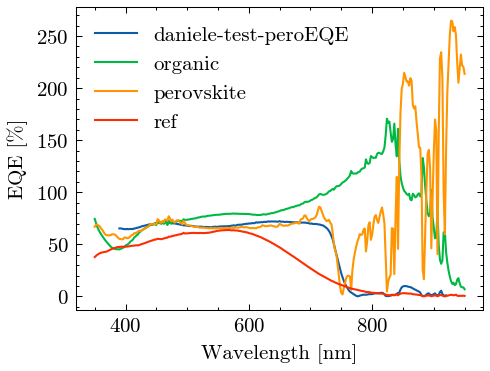

In [26]:
plt.figure()
for d,r in zip(eqe_dat,eqe_runs):
    plt.plot(d['wavelength'],d['EQE'],label=r)

plt.plot(eqe_ref_dat['wavelength'],eqe_ref_dat['EQE'],label='ref')

plt.legend()

plt.xlabel('Wavelength [nm]')
plt.ylabel('EQE [%]')

Text(0, 0.5, 'I [mA]')

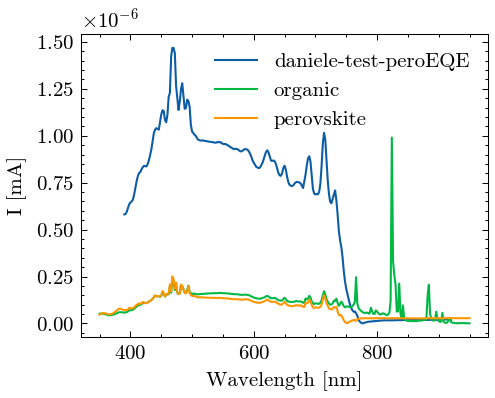

In [27]:
plt.figure()
for d,r in zip(eqe_dat,eqe_runs):
    plt.plot(d['wavelength'],d['I'],label=r)
plt.legend()

plt.xlabel('Wavelength [nm]')
plt.ylabel('I [mA]')

Calculate the theoretical Jsc under standardized illumination.

## Spectral mismatch

In [28]:
eqe_dat[0], eqe_ref_dat

(     wavelength             I        EQE  dummy
 0           390  5.811290e-07  65.311500    NaN
 1           392  5.824310e-07  65.332700    NaN
 2           394  5.955080e-07  65.203400    NaN
 3           396  6.159210e-07  64.736200    NaN
 4           398  6.356520e-07  64.745900    NaN
 ..          ...           ...        ...    ...
 261         912  2.156670e-08   5.554790    NaN
 262         914  2.117190e-08   2.340380    NaN
 263         916  2.090000e-08   1.057960    NaN
 264         918  2.102800e-08   0.874312    NaN
 265         920  2.061140e-08   1.039430    NaN
 
 [266 rows x 4 columns],
      wavelength       EQE
 0           350  37.83840
 1           352  38.97870
 2           354  39.95510
 3           356  40.75810
 4           358  41.39740
 ..          ...       ...
 296         942   0.59459
 297         944   0.68128
 298         946   0.57345
 299         948   0.78988
 300         950   0.54610
 
 [301 rows x 2 columns])

(300.0, 1000.0)

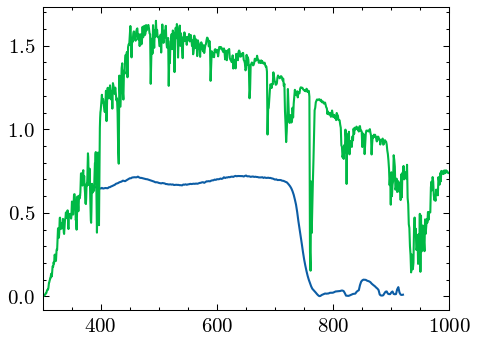

In [29]:
plt.figure()
plt.plot(eqe_dat[0]['wavelength'],eqe_dat[0]['EQE']/100,label=r)
plt.plot(am15g['wl'],am15g['global'], label='Global tilt')


plt.xlim(300,1000)

In [30]:
l1=400
l2=750

In [31]:
am15g_interp = [0]*len(eqe_dat)
for i,d in enumerate(eqe_dat):
    am15g_interp[i]=np.interp(d['wavelength'][d['wavelength']>=l1][d['wavelength']<=l2],am15g['wl'],am15g['global'])
d = eqe_ref_dat
am15g_interp_ref = np.interp(d['wavelength'][d['wavelength']>=l1][d['wavelength']<=l2],am15g['wl'],am15g['global'])

[334.09350572592, 388.88138921192, 330.7908544805, 246.83846533980002]

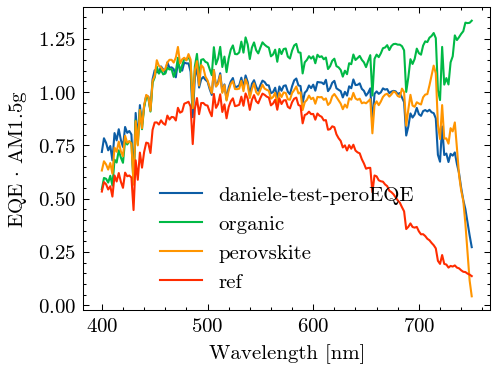

In [32]:
mm_am15g=[]
plt.figure()
for i,(d,r) in enumerate(zip(eqe_dat,eqe_runs)):
    plt.plot(d['wavelength'][d['wavelength']>=l1][d['wavelength']<=l2],am15g_interp[i]*d['EQE'][d['wavelength']>=l1][d['wavelength']<=l2]/100,label=r)
    mm_am15g.append(np.sum(am15g_interp[i]*d['EQE'][d['wavelength']>=l1][d['wavelength']<=l2]/100)*2)
d = eqe_ref_dat
plt.plot(d['wavelength'][d['wavelength']>=l1][d['wavelength']<=l2],am15g_interp_ref*eqe_ref_dat['EQE'][d['wavelength']>=l1][d['wavelength']<=l2]/100,label='ref')
mm_am15g.append(np.sum(am15g_interp_ref*d['EQE'][d['wavelength']>=l1][d['wavelength']<=l2]/100)*2)
plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel('EQE $\cdot$ AM1.5g')

# maybe try 390-750 nm instead of 350-950 nm
mm_am15g

In [33]:
spec_interp = [0]*len(eqe_dat)
j=3
for i,d in enumerate(eqe_dat):
    spec_interp[i]=np.interp(d['wavelength'][d['wavelength']>=l1][d['wavelength']<=l2],spec_dat[j]['Wave'],spec_dat[j]['Corr'])
d=eqe_ref_dat
spec_interp_ref = np.interp(d['wavelength'][d['wavelength']>=l1][d['wavelength']<=l2],spec_dat[j]['Wave'],spec_dat[j]['Corr'])

[6876486.384023039, 7754217.238789463, 6798337.329563244, 5468545.456745404]

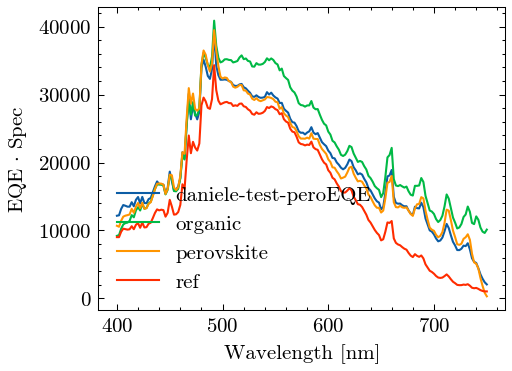

In [34]:
mm_spec=[]
plt.figure()
for i,(d,r) in enumerate(zip(eqe_dat,eqe_runs)):
    plt.plot(d['wavelength'][d['wavelength']>=l1][d['wavelength']<=l2],spec_interp[i]*d['EQE'][d['wavelength']>=l1][d['wavelength']<=l2]/100,label=r)
    mm_spec.append(np.sum(spec_interp[i]*d['EQE'][d['wavelength']>=l1][d['wavelength']<=l2]/100)*2)
d=eqe_ref_dat
plt.plot(d['wavelength'][d['wavelength']>=l1][d['wavelength']<=l2],spec_interp_ref*d['EQE'][d['wavelength']>=l1][d['wavelength']<=l2]/100,label='ref')
mm_spec.append(np.sum(spec_interp_ref*d['EQE'][d['wavelength']>=l1][d['wavelength']<=l2]/100)*2)
plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel('EQE $\cdot$ Spec')

# maybe try 390-800 nm instead
mm_spec

In [35]:
for i, (a,s,r) in enumerate(zip(mm_am15g,mm_spec,eqe_runs)):
    print(a/s*mm_spec[-1]/mm_am15g[-1],r)

1.0763671506180366 daniele-test-peroEQE
1.1110617191292576 organic
1.0779776896230735 perovskite
